# Initial Analysis

NOTE: This notebook requires Python >3.6

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc   

import os
import numpy as np
import pandas as pd
import xarray as xr

## Preprocessing of model output

The raw data should be located in *raw* and is processed using **ldndc2nc** (utilizing ldndc2nc.conf). The processed files should also be placed into *raw* and all further processing will end up in data. Due to space constraints I currently only upload the averaged netCDF files there...

In [2]:
# process the txt output of ldndc into netcdfs files first (using ldndc2nc)...
#
# > ldndc2nc -c ldndc2nc.conf -r PH_MISC2.nc,cid -y 2000-2012 -o raw/int_awd_lm_daily.nc raw/PH_arable_output_int_awd_lm 
# > ...
#

In [3]:
# helper file with area and rice fractions
dsr = xr.open_dataset("data/PH_MISC2.nc")

In [4]:
not_yet_processed = True
for intensity in ['ext', 'int']:
    for wtype in ['awd', 'cf', 'rf']:
        for mtype in ['hm', 'lm']:
            scen = f"{intensity}_{wtype}_{mtype}"
            print(f'processing {scen}...')

            ds = xr.open_dataset(f'raw/{scen}_daily.nc')[['dC_ch4_emis','dN_n2o_emis','dC_bud']]

            if not_yet_processed:
                is_not_null = np.invert(np.isnan( ds['dC_ch4_emis'][0].values) )
                not_yet_processed = False
                
            if os.path.isfile(f'data/{scen}_yearly.nc') == False:
                dsy = ds.groupby('time.year').sum(dim='time', keep_attrs=True).where(is_not_null)
                dsy.to_netcdf(f'data/{scen}_yearly.nc', format='NETCDF4_CLASSIC')
            else:
                dsy = xr.open_dataset(f'data/{scen}_yearly.nc')

processing ext_awd_hm...
processing ext_awd_lm...
processing ext_cf_hm...
processing ext_cf_lm...
processing ext_rf_hm...
processing ext_rf_lm...
processing int_awd_hm...
processing int_awd_lm...
processing int_cf_hm...
processing int_cf_lm...
processing int_rf_hm...
processing int_rf_lm...


## Aggregate and compute landuse-averaged results

In [5]:
def compute_gwp(ch4=0, n2o=0):
    return (ch4 * 28 * (16./12.) + n2o * 298 * (44./28.)) * 0.001

def compute_ysgwp(gwp, yield_c):
    return gwp*1000 / (yield_c * 0.001 * (1.0 / 0.45))
    

In [6]:
# aggregate
is_not_null = 'None'

df = pd.DataFrame({'CH4': [0, 0], 'N2O': [0,0], 'GWP': [0.0], 'YSGWP': [0,0]}, 
                   index=['AWD', 'CF'])

for intensity in ['ext', 'int']:

    # awd = 0.3 * rf + 0.7 * awd
    mtype='hm'
    ds_awd_hm = xr.open_dataset(f'data/{intensity}_awd_{mtype}_yearly.nc')
    ds_rf_hm  = xr.open_dataset(f'data/{intensity}_rf_{mtype}_yearly.nc')
    ds_cf_hm  = xr.open_dataset(f'data/{intensity}_cf_{mtype}_yearly.nc')

    mtype='lm'
    ds_awd_lm = xr.open_dataset(f'data/{intensity}_awd_{mtype}_yearly.nc')
    ds_rf_lm  = xr.open_dataset(f'data/{intensity}_rf_{mtype}_yearly.nc')
    ds_cf_lm  = xr.open_dataset(f'data/{intensity}_cf_{mtype}_yearly.nc')
    
    # compute weighted averages
    ds_awd = (ds_rf_hm * 0.3 * 0.5) + (ds_awd_hm * 0.7 * 0.5) + (ds_rf_lm * 0.3 * 0.5) + (ds_awd_lm * 0.7 * 0.5)
    ds_cf  = (ds_rf_hm * 0.3 * 0.5) + (ds_cf_hm * 0.7 * 0.5) + (ds_rf_lm * 0.3 * 0.5) + (ds_cf_lm * 0.7 * 0.5)

    # aggreagte to annual data and write new files
    ds_awd = ds_awd.sel(year=slice(None,2010)).mean(dim='year')
    ds_awd.to_netcdf(f'data/{intensity}_awd.nc', format='NETCDF4_CLASSIC')
    ds_cf = ds_cf.sel(year=slice(None,2010)).mean(dim='year')
    ds_cf.to_netcdf(f'data/{intensity}_cf.nc', format='NETCDF4_CLASSIC')
    
    # calculate totals:
    totals_awd = (ds_awd * (dsr['ricearea']*0.01 * dsr['area_ha'])).sum()
    totals_cf = (ds_cf * (dsr['ricearea']*0.01 * dsr['area_ha'])).sum()

    print(f"\nIntensity: {intensity}")
    
    for v, sv in zip(['dC_ch4_emis', 'dN_n2o_emis', 'dC_bud'], ['CH4', 'N2O', 'Bud']):
        df.loc['AWD', sv] = totals_awd[v].values
        df.loc['CF',  sv] = totals_cf[v].values

    for s in ['AWD', 'CF']:
        df.loc[s, 'GWP']   = compute_gwp(df.loc[s,'CH4'], df.loc[s, 'CH4'])
        df.loc[s, 'YSGWP'] = compute_ysgwp(df.loc[s,'GWP'], df.loc[s, 'Bud'])

    # cleanup
    del df['Bud']
    
    df['CH4'] *= 0.001
    df['N2O'] *= 0.001
    
    df = df.round().astype(int)
    
    display(df)


Intensity: ext


,CH4,N2O,GWP,YSGWP
AWD,646351,3041,326807463,15762
CF,751359,2994,379901171,18349



Intensity: int


,CH4,N2O,GWP,YSGWP
AWD,1508312,3554,762631388,19479
CF,1930886,3502,976292703,25023


## Plotting

In [7]:
# larger font
import matplotlib
matplotlib.rcParams.update({'font.size': 10})
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shapereader    

# Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
countries = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_0_countries',
    scale='50m',
    facecolor='none')

countries2 = shapereader.natural_earth(resolution='50m',
                                      category='cultural',
                                      name='admin_0_countries')

for country in shapereader.Reader(countries2).records():
    if country.attributes['SU_A3'] == 'PHL':
        vietnam = country.geometry
        break
else:
    raise ValueError('Unable to find the PHL boundary.')
    
ocean = cfeature.NaturalEarthFeature(
        category='physical', 
        name='ocean', 
        scale='50m',
        edgecolor='face',
        facecolor=cfeature.COLORS['water'])

In [8]:
# labels
Dname = {}
Dname['dC_ch4_emis'] = r'$\mathregular{CH_4\ emission\ [kg\ C\ ha^{-1}\ yr^{-1}]}$'
Dname['dN_n2o_emis'] = r'$\mathregular{N_2O\ emission\ [kg\ N\ ha^{-1}\ yr^{-1}]}$'
Dname['GWP']         = r'$\mathregular{GWP\ [Mg\ CO_2\ eq\ ha^{-1}\ yr^{-1}]}$'
Dname['YSGWP']       = r'$\mathregular{Yield-scaled\ GWP\ [kg\ CO_2\ eq\ Mg^{-1}\ yr^{-1}]}$'

Management system: awd
Management system: cf


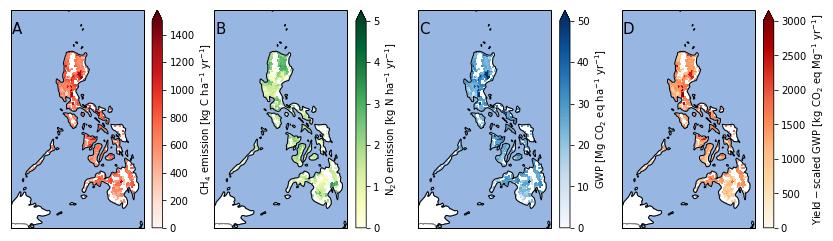

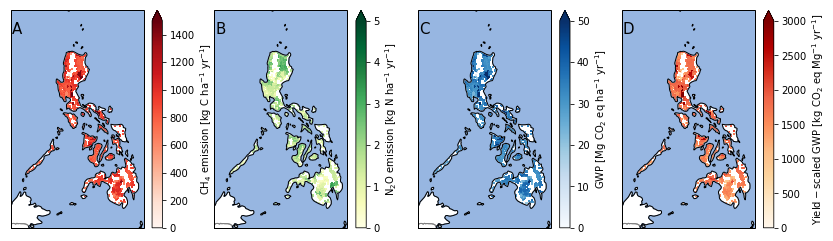

In [9]:
for system in ['awd', 'cf']:
        davg = xr.open_dataset(f'data/int_{system}.nc')
    
        da_ch4   = davg['dC_ch4_emis']
        da_n2o   = davg['dN_n2o_emis']
        da_yield = davg['dC_bud']

        # compute GWP
        da_gwp    = compute_gwp(da_ch4, da_n2o)
        da_yscale = compute_ysgwp(da_gwp, da_yield)
    
        print(f"Management system: {system}")
        
        fig, ax = plt.subplots(1, 4, figsize=(14,4), subplot_kw=dict(projection=ccrs.PlateCarree()))

        for i, ax in enumerate(ax.flat):
            ax.set_extent([116, 127, 4, 22])
            
            # add map elements
            ax.add_feature(countries, edgecolor='gray')     # country borders
            ax.add_geometries(vietnam, ccrs.PlateCarree(), edgecolor='white', facecolor='none')
            ax.add_feature(ocean)                           # ocean
            ax.coastlines(resolution='50m')                 # coastlines

            if i == 0:
                colors = plt.cm.Reds
                p=xr.plot.pcolormesh(da_ch4, cbar_kwargs={'label': Dname['dC_ch4_emis']}, 
                        ax=ax, transform=ccrs.PlateCarree(), cmap=colors, 
                        vmin=0, vmax=1500, extend='max' )

            elif i == 1:
                colors = plt.cm.YlGn
                #da_n2o = da_n2o.rename(Dname['dN_n2o_emis'])
                xr.plot.pcolormesh(da_n2o, cbar_kwargs={'label': Dname['dN_n2o_emis']},
                        ax=ax, transform=ccrs.PlateCarree(), cmap=colors, 
                        #extend='max', vmin=0, vmax=7, robust=True )
                        vmin=0, vmax=5, extend='max' )

            elif i == 2:
                colors = plt.cm.Blues
                xr.plot.pcolormesh(da_gwp, cbar_kwargs={'label': Dname['GWP']}, 
                        ax=ax, transform=ccrs.PlateCarree(), cmap=colors,
                        vmin=0, vmax=50, extend='max')

            elif i == 3:
                colors = plt.cm.OrRd
                xr.plot.pcolormesh(da_yscale, cbar_kwargs={'label': Dname['YSGWP']}, 
                        ax=ax, transform=ccrs.PlateCarree(), cmap=colors, 
                        vmin=0, vmax=3000, extend='max' )

            sublabels='ABCD'
            ax.add_patch(mpatches.Rectangle(xy=[116.25, 19], width=1, height=1,
                                            facecolor='none',
                                            edgecolor='black',
                                            alpha=1.0,
                                            transform=ccrs.PlateCarree()))
                                            
            ax.text(116.5, 20.45, sublabels[i], fontsize=15,
                horizontalalignment='center', verticalalignment='center', 
                transform=ccrs.PlateCarree())


        plt.savefig(f'plots/{system}_2000-2010.png', bbox_inches='tight', dpi=600)

        del fig, ax